In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Data preprocessing

In [2]:
# Reading in LA County case and death data
# 1/26/2020 through 2/22/2022 for this iteration
la = pd.read_csv('https://raw.githubusercontent.com/nmonozon/modeling-covid-19/main/Datasets/covid-19-los-angeles-county.csv', index_col='date')[0:759]

In [3]:
la.tail()

,day,county,state,fips,cases,deaths
date,,,,,,
2022-02-18,755,Los Angeles,California,6037.0,2777869,30216.0
2022-02-19,756,Los Angeles,California,6037.0,2781027,30300.0
2022-02-20,757,Los Angeles,California,6037.0,2783657,30356.0
2022-02-21,758,Los Angeles,California,6037.0,2784980,30376.0
2022-02-22,759,Los Angeles,California,6037.0,2786153,30411.0


In [4]:
# Column for new cases per day
la['new_cases'] = 0 
for i in range(1,len(la)):
    la['new_cases'].iloc[i] = la['cases'].iloc[i] - la['cases'].iloc[i-1]

C:\Users\Nicolas\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
for i in range(3,31,1):
    la[f'new_cases_lag_{i}'] = la['new_cases'].shift(i)

In [6]:
predictors = [col for col in la.columns if col.startswith('new_cases_lag_')] + ['new_cases']
model1_df = la[predictors]

In [7]:
model1_df.dropna(inplace = True)

C:\Users\Nicolas\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [8]:
la['week'] = la['day'] // 7
weekly_la = la.groupby('week')[['new_cases']].sum()
weekly_la['one_week_before'] = weekly_la['new_cases'].shift(1)
weekly_la['change'] = weekly_la['new_cases'].shift(1) - weekly_la['new_cases'].shift(2)
weekly_la.dropna(inplace = True)
weekly_la = weekly_la.iloc[1::]

In [9]:
weekly_la

,new_cases,one_week_before,change
week,,,
3,0,0.0,0.0
4,0,0.0,0.0
5,12,0.0,0.0
6,27,12.0,12.0
7,252,27.0,15.0
...,...,...,...
104,181641,256736.0,-27746.0
105,99977,181641.0,-75095.0
106,42036,99977.0,-81664.0


In [10]:
# RF cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv = cross_val_score(rf, model1_df.drop(columns = ['new_cases']), 
                     model1_df['new_cases'], scoring = 'neg_mean_absolute_error', cv = 5)
-1 * np.mean(cv) / model1_df.new_cases.mean()

0.5102021100711419

In [11]:
# Alternate approach: Predicting Weekly Cases
weekly_la = la.groupby('week')[['new_cases']].sum()

In [12]:
weekly_la['one_week_before'] = weekly_la['new_cases'].shift(1)
weekly_la['momentum'] = weekly_la['new_cases'].shift(1) - weekly_la['new_cases'].shift(2)

In [13]:
weekly_la.dropna(inplace = True)

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv = cross_val_score(rf, weekly_la.drop(columns = ['new_cases']), 
                     weekly_la['new_cases'], scoring = 'neg_mean_absolute_error', cv = 5)
-1 * np.mean(cv) / weekly_la.new_cases.mean()

0.42990622677730855

In [15]:
rf.fit(weekly_la.drop(columns = ['new_cases']), 
                     weekly_la['new_cases'])
preds_rf = rf.predict(weekly_la.drop(columns = ['new_cases']))

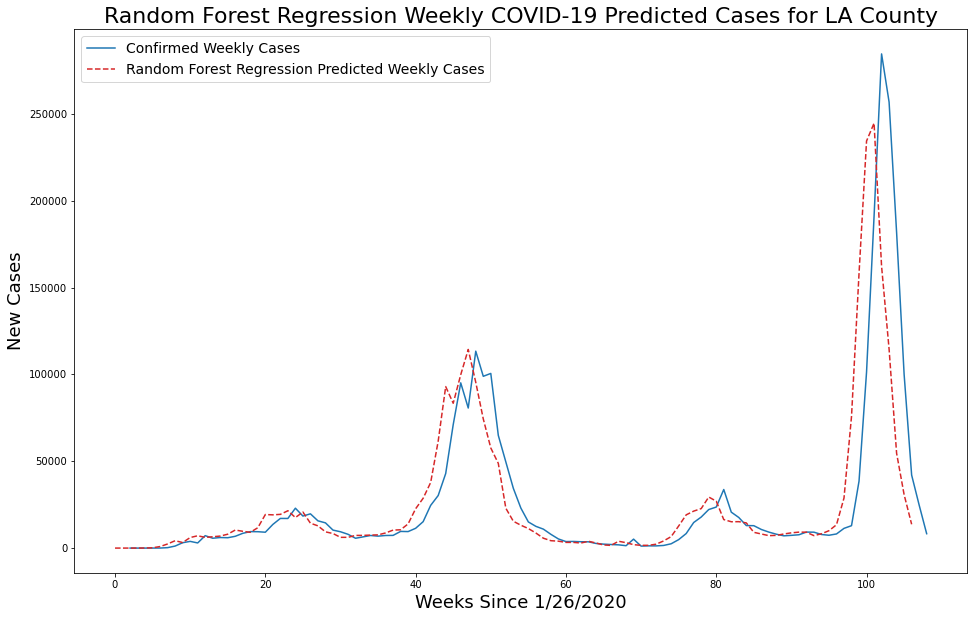

In [16]:
plt.figure(figsize = (16,10))
plt.plot(weekly_la['new_cases'], label = 'Confirmed Weekly Cases')
plt.plot(rf.predict(weekly_la.drop(columns = ['new_cases'])), label = 'Random Forest Regression Predicted Weekly Cases', color='tab:red', linestyle='dashed')
plt.xlabel('Weeks Since 1/26/2020', fontsize=18)
plt.ylabel('New Cases', fontsize=18)
plt.title('Random Forest Regression Weekly COVID-19 Predicted Cases for LA County', fontsize=22)
plt.legend(prop={'size': 14})
# plt.savefig("rf.png")
# files.download("rf.png") 

In [17]:
from sklearn.metrics import mean_absolute_error
print('MAE:mean_absolute_error(weekly_la['new_cases'], preds_rf)

3335.366507343125

In [18]:
from sklearn.metrics import r2_score
print('R^2:', r2_score(weekly_la['new_cases'], preds_rf))

R^2: 0.9735012991072503
